In [1]:
import numpy as np
import matplotlib.pyplot as plt
import paths
import os
from dime import DopplerImaging, load_data_from_pickle, make_fakemap, simulate_data
from config import load_config
import lsd_utils as lsd
from astropy.io import fits
from scipy import interpolate

/Users/xqchen/workspace/doppler-imaging-maxentropy/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
instru = "METIS"
target = "W1049B"
band = "L"
params_run, goodchips, modelspec = load_config(instru, target, band)
model_datafile = paths.data / f"fitted/{instru}_{target}_{band}_{modelspec}.pickle"
savedir = f"run_1049b_gcm_{band}"
if not os.path.exists(paths.figures / savedir):
    os.makedirs(paths.figures / savedir)

print("Using data from: ", model_datafile)
print("Using model spectrum: ", modelspec)
print("params_run:\n", params_run)

Using data from:  /Users/xqchen/workspace/doppler-imaging-maxentropy/data/fitted/METIS_W1049B_L_t1400g1000f2.pickle
Using model spectrum:  t1400g1000f2
params_run:
 {'nk': 150, 'nobs': 14, 'phases': array([0.16951029, 0.62100994, 1.07310523, 1.52543424, 1.97694143,
       2.42900657, 2.90204748, 3.35412769, 4.01374905, 4.54115961,
       5.01049094, 5.46844468, 5.9227416 , 6.37455037]), 'timestamps': array([0.134892  , 0.49418401, 0.85395001, 1.213902  , 1.5732    ,
       1.93294201, 2.30937601, 2.66913001, 3.19404001, 3.61374   ,
       3.987222  , 4.35165001, 4.71316801, 5.07270601]), 'inc': 80, 'vsini': 29, 'rv': 0.0001, 'lld': 0.4, 'eqarea': True, 'nlat': 10, 'nlon': 20, 'alpha': 2000}


In [3]:
# Load data from pickle fit
wav_nm, template, observed, error = load_data_from_pickle(model_datafile, goodchips, instru="METIS", pad=10)

Data loaded from file /Users/xqchen/workspace/doppler-imaging-maxentropy/data/fitted/METIS_W1049B_L_t1400g1000f2.pickle.
observed: (20, 4, 1980)
template: (20, 4, 1980)
wav: (4, 1980)


In [5]:
dmap = DopplerImaging(wav_nm, goodchips, params_dict=params_run, instru="METIS")
dmap.load_data(observed, template, error)
print(dmap)

nobs: 14, nchip: 4, npix: 1980
Created equa-area grid of 216 cells, in 12 latitude grids with [ 6 12 17 21 25 27 27 25 21 17 12  6] lontitude cells.
DopplerImaging Class with
             instru=METIS
             nobs=14
             chip=4
             npix=1980
             nk=150


/Users/xqchen/workspace/doppler-imaging-maxentropy/src/ELL_map_class.py:226: RuntimeWarning: divide by zero encountered in double_scalars
  np.sqrt(1. - np.tan(inc)**2 / np.tan(self.corners_latlon[0,ii])**2)
/Users/xqchen/workspace/doppler-imaging-maxentropy/src/ELL_map_class.py:226: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(1. - np.tan(inc)**2 / np.tan(self.corners_latlon[0,ii])**2)


chip 0


/Users/xqchen/workspace/doppler-imaging-maxentropy/venv/lib/python3.9/site-packages/numpy/linalg/linalg.py:2158: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


chip 1
chip 2
chip 3


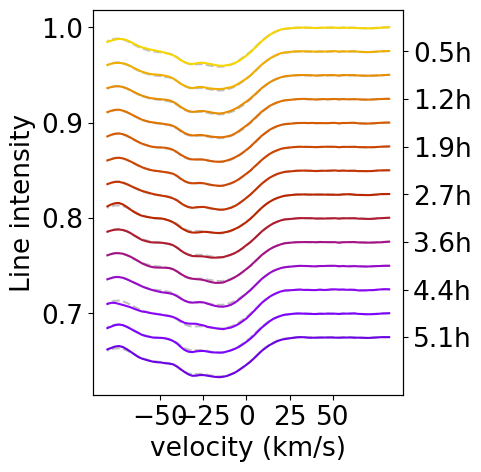

In [6]:
dmap.make_lsd_profile(modname='L', shiftkerns=True, shiftmods=True, plot_lsd_profiles=True, plot_deviation_map=False, colorbar=True, savedir=paths.figures/f"{savedir}/")

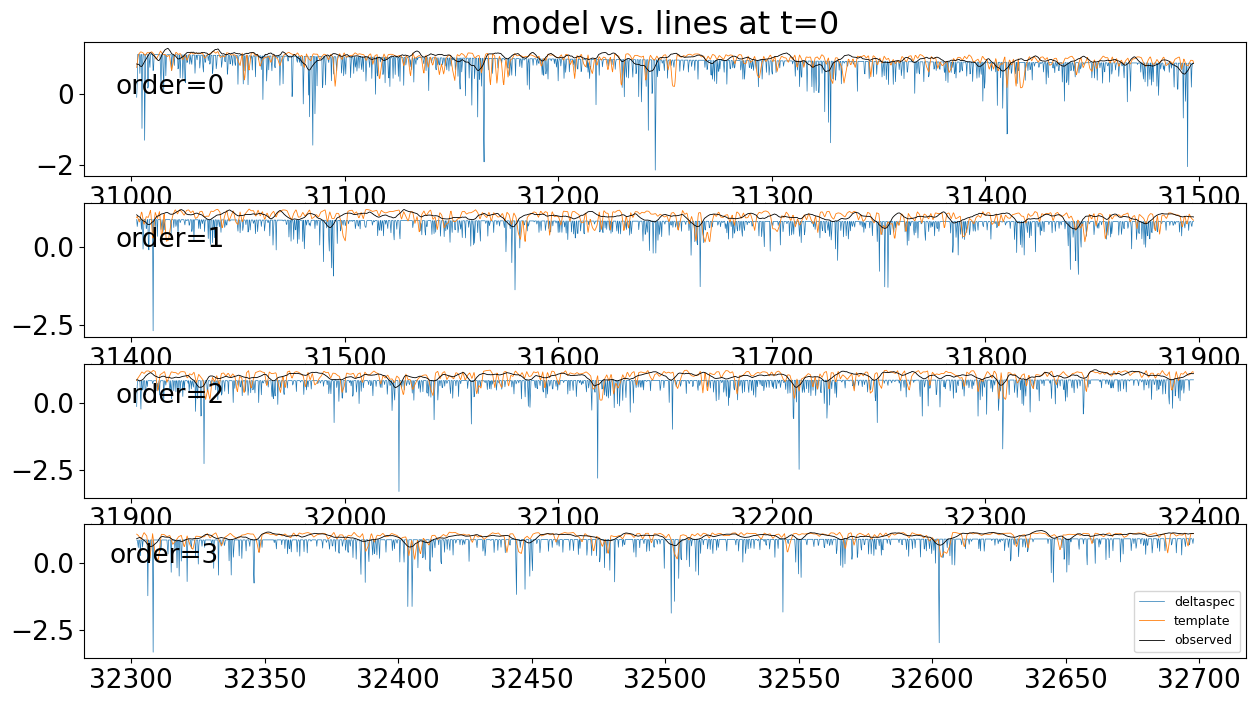

In [7]:
dmap.plot_lsd_spectra()

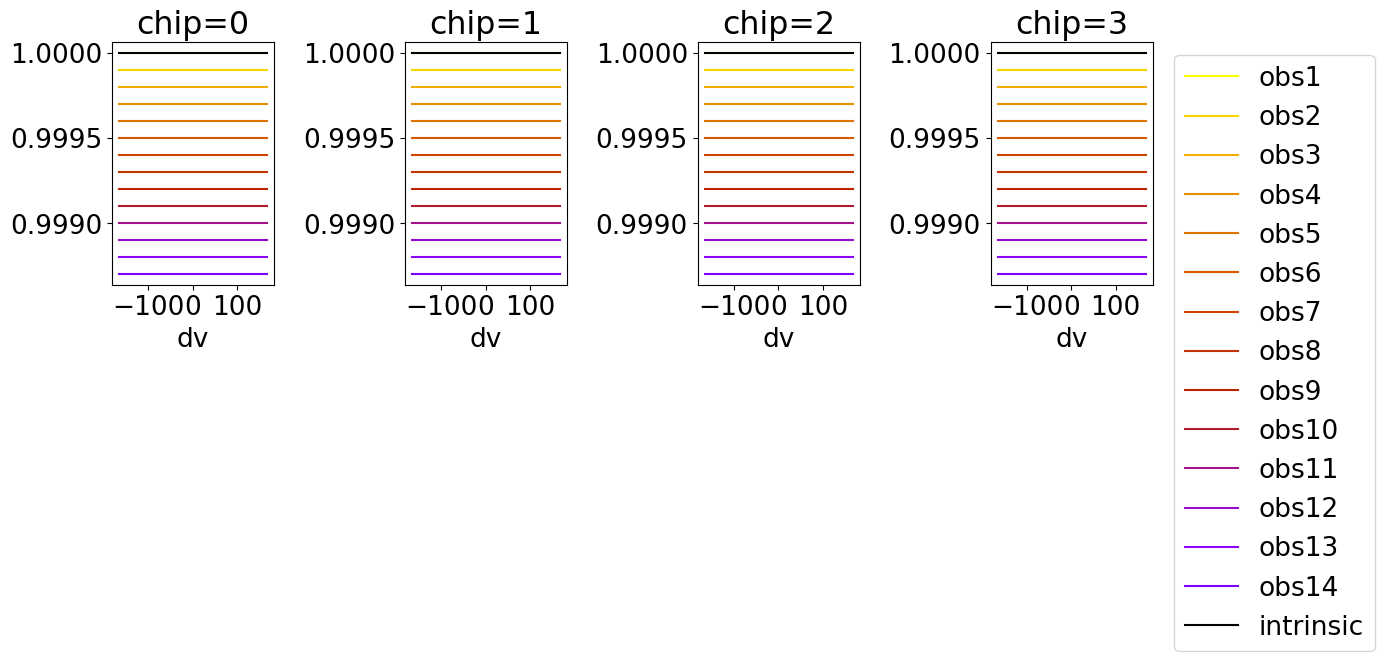

In [13]:
line_profiles = dmap.obskerns_norm
gap = 0.0001
colors = [plt.cm.gnuplot_r(x) for x in np.linspace(0, 1, dmap.nobs+4)]
plt.figure(figsize=(dmap.nchip*3, 4))
for i, jj in enumerate(dmap.goodchips):
    plt.subplot(1, dmap.nchip, i+1)
    for n in range(dmap.nobs):
        plt.plot(dmap.dv, line_profiles[n,i] - gap*n, color=colors[n], label=f"obs{n+1}")
    plt.plot(dmap.dv, 1 - dmap.intrinsic_profiles[i], color='k', label="intrinsic")
    plt.title(f"chip={jj}")
    plt.xlabel("dv")
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

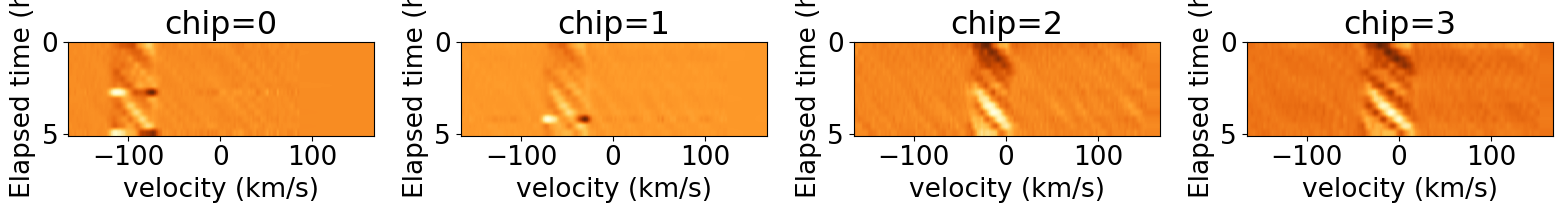

In [8]:
plt.figure(figsize=(dmap.nchip*4, 3))
timeav_profiles = np.zeros((dmap.nchip, dmap.nk))
line_profiles = dmap.obskerns_norm
for i, jj in enumerate(dmap.goodchips):
    timeav_profiles[i] = line_profiles[:,i].mean(axis=0) # averaged LP over times
    #TODO: change timeav_profiles to median
    plt.subplot(1, dmap.nchip, i+1)
    plt.imshow(line_profiles[:,i] - timeav_profiles[i], 
        extent=(dmap.dv.max(), dmap.dv.min(), dmap.timestamps[-1], 0),
        aspect=int(20),
        cmap='YlOrBr') # positive diff means dark spot
    plt.xlim(dmap.dv.min(), dmap.dv.max()),
    plt.xlabel("velocity (km/s)")
    plt.ylabel("Elapsed time (h)")
    plt.title(f"chip={jj}")
plt.tight_layout()


In [9]:
dmap.solve(create_obs_from_diff=True, solver='scipy')

metric: -10673.76, chisq: 144.67, entropy: 5.37


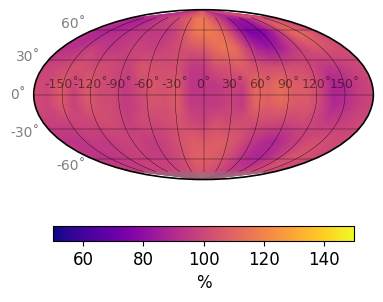

In [10]:
dmap.plot_mollweide_map(vmin=50, vmax=150, colorbar=True, savedir=paths.figures/f"{savedir}/solver1.png")

<Axes: xlabel='$\\it{nobs}$'>

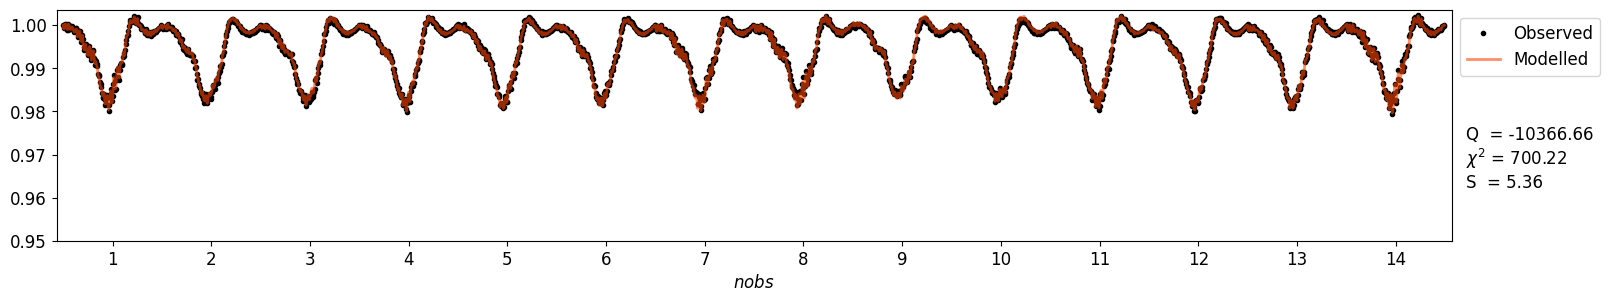

In [53]:
dmap.plot_fit_results_1d(savedir=paths.figures/f"{savedir}/fit1d_{target}_{band}.png")

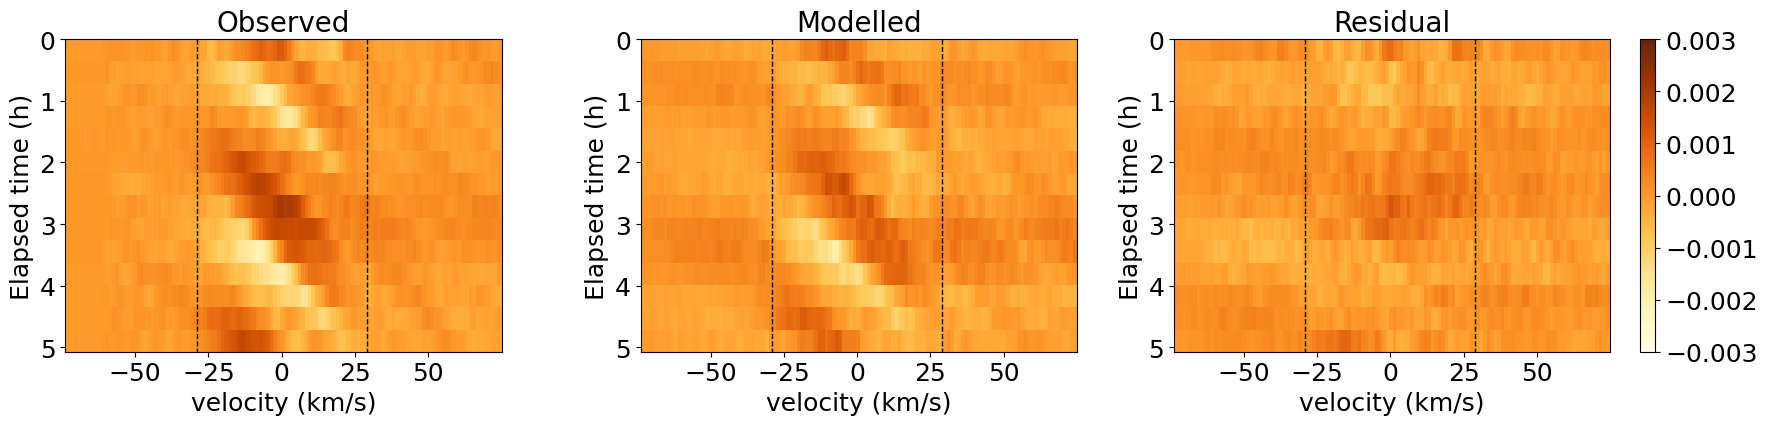

In [59]:
plt.figure(figsize=(18,4.6))
sz=20
vmax=0.003
plt.subplot(131)
dmap.plot_deviation_map(dmap.obs_2d - dmap.flatmodel_2d, vmax=vmax, newfig=False)
plt.title("Observed", fontsize=sz)
plt.subplot(132)
dmap.plot_deviation_map(dmap.bestmodel_2d - dmap.flatmodel_2d, vmax=vmax, newfig=False)
plt.title("Modelled", fontsize=sz)
plt.subplot(133)
dmap.plot_deviation_map(dmap.obs_2d - dmap.bestmodel_2d, vmax=vmax, newfig=False)
plt.title("Residual", fontsize=sz)
plt.colorbar()